## Лабораторная работа 3
_Команда 13_ <br>
_Кондратов, Малышева, Оплетина, Штрейх_


## Шаг 1 

Выберите подвыборку с основными переменными для дальнейшего анализа. Затем для каждой из них:

In [7]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.stats import gamma, lognorm, rayleigh, norm, logistic, poisson, binom, hypergeom
from scipy.stats import kstest, goodness_of_fit, fit, chisquare, power_divergence, anderson
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Импорт файла из гугл диска
# Популярный датасет про красные вина (https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)
path = 'https://drive.google.com/file/d/1qqL-eq0wU2xTJOyX_kfz3f4NAo5aG3RF/view?usp=drive_link'
path = 'https://drive.google.com/uc?id=' + path.split('/')[-2]
data = pd.read_csv(path)

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
data.nunique()

fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
dtype: int64

Дадим расшифровку выбранных признаков

alcohol - the percent alcohol content of the wine

pH - describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic)

density - the density of water is close to that of water depending on the percent alcohol and sugar content

quality -  (score between 0 and 10)


In [263]:
# выберем нужные признаки
cols_to_select = ['alcohol', 'pH', 'density',
                  'quality']
data_select = data[cols_to_select]

In [6]:
# проверим наличие пропусков
data_select.isnull().sum()

alcohol    0
pH         0
density    0
quality    0
dtype: int64

## Шаг 2

Вам необходимо сделать непараметрическую оценку плотности распределения в виде гистограммы и используя функцию плотности ядра (или закона вероятности в случае дискретной СВ).

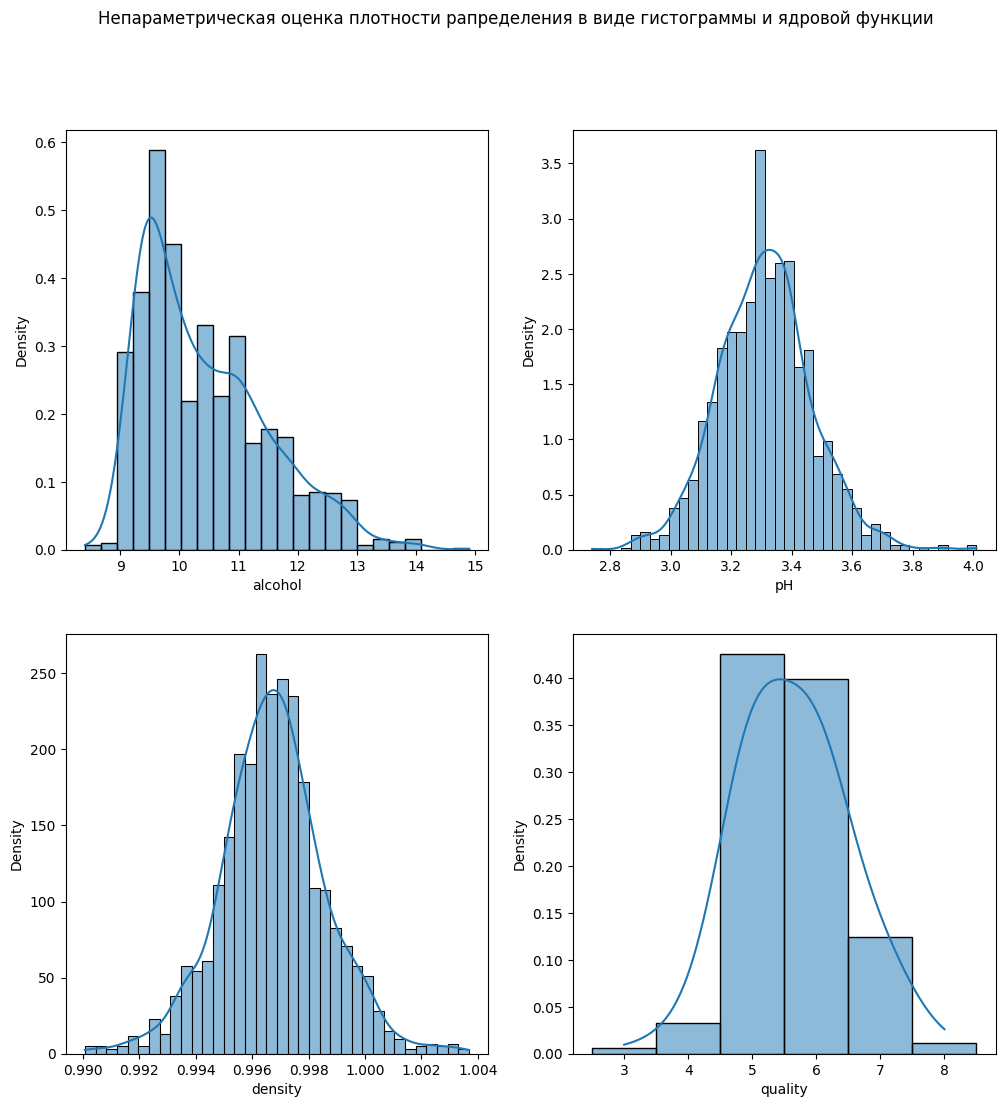

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
q = 0
for col_name in data_select.columns:
    i = q // 2
    j = q % 2
    if col_name != 'quality':
        sns.histplot(data_select[col_name], kde=True,
                     ax=axes[i, j], stat='density')
    else:
        sns.histplot(data_select[col_name], kde=True, kde_kws={'bw_adjust': 3},
                     ax=axes[i, j], stat='density', discrete=True)
    q += 1
fig.suptitle(
    'Непараметрическая оценка плотности рапределения в виде гистограммы и ядровой функции')
plt.show()

## Шаг 3

Вам необходимо провести оценку порядковых статистик и представить их в виде “ящиков с усами”

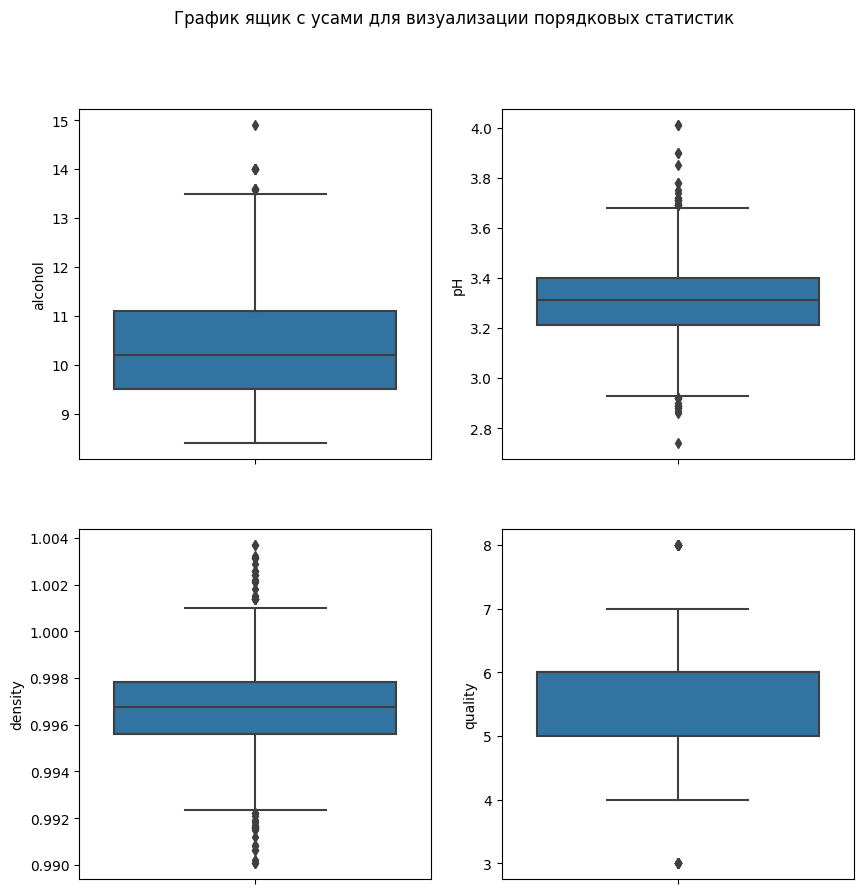

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
q = 0
for col_name in data_select.columns:
    i = q // 2
    j = q % 2
    q += 1
    sns.boxplot(y=data_select[col_name], ax=axes[i, j])
fig.suptitle(
    'График ящик с усами для визуализации порядковых статистик')
plt.show()

!!!!! Мб что-то написать про эту картинку

## Шаг 4

Найдите одно или несколько теоретических распределений, которые могли бы описать вашу выборку на основе результатов непараметрического анализа.

Наши данные не могут принимать отрицательне значения, поэтому стоит задуматься над тем, чтобы  использовать распределения, которые определены на $\mathbb{R}^+$. Например, Гамма распределение или распределение Рэлея. Хотя Гаусса и Логистическое тоже стоит проверить. Но при сэмплировании стоит ставить ограничение на неотрицательность. Или воспользоваться логнормальным. Для дискретной СВ quality стоит попробовать распределение Пуассона, Биномиальное и Гипербиномиальное.

## Шаг 5

Оценить параметры выбранных распределений, используя методы максимального правдоподобия и метод наименьших квадратов.

Начем с простого. Попробуем найти параметры распределения Гаусса

Функция плотности

$$f(x) = \frac{1}{\sqrt{2 \sigma^2 \pi}} e^{\frac{1}{2} (\frac{x - \mu}{\sigma})^2}$$

Тогда функция максимального правдоподобия имеет вид

$$L(\mu, \sigma^2; x_1, \ldots, x_n) = (2 \pi \sigma^2)^{(-n/2)} \exp{(-\frac{1}{2\sigma^2} \sum^{n}_{j = 1} (x_j - \mu)^2)}$$

Возьмем логарифм

$$Loglike(\mu, \sigma^2; x_1, \ldots, x_n) = -\frac{n}{2} ln(2 \pi) -\frac{n}{2} ln(\sigma^2) -\frac{1}{2\sigma^2} \sum^{n}_{j = 1} (x_j - \mu)^2 \rightarrow \max_{\mu, \sigma^2}$$

Для оптимизации часть $-\frac{n}{2} ln(2 \pi)$ можно опустить так как она не зависит от параметров

Перейдем к задаче минимизации

$$-Loglike(\mu, \sigma^2; x_1, \ldots, x_n) = \frac{n}{2} ln(\sigma^2) +\frac{1}{2\sigma^2} \sum^{n}_{j = 1} (x_j - \mu)^2 
\rightarrow \min_{\mu, \sigma^2}$$

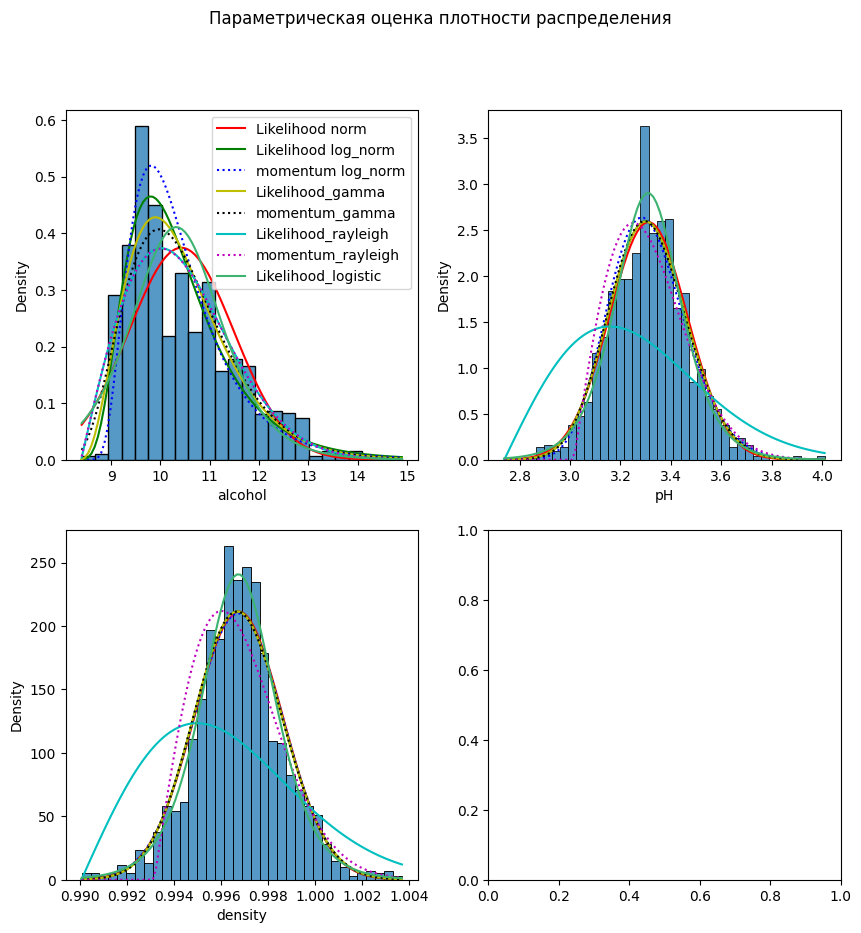

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

q = 0

selected_cols = ['alcohol', 'pH', 'density']

for feature in selected_cols:

    i = q // 2
    j = q % 2
    q += 1

    x = data_select[feature].to_numpy()

    def log_like_norm(param):
        mu, sigma = param
        return data_select.shape[0]/2*np.log(sigma)+1/(2*sigma)*(x - mu).dot(x - mu)

    res = opt.minimize(log_like_norm, [1, 1], method='Nelder-Mead')

    sns.histplot(data_select[feature], ax=ax[i, j], stat='density')
    ax[i, j].plot(np.linspace(data_select[feature].min(), data_select[feature].max(), 100), norm.pdf(
        np.linspace(data_select[feature].min(), data_select[feature].max(), 100), res['x'][0], np.sqrt(res['x'][1])), 'r-', label='Likelihood norm')

    a, loc, scale = lognorm.fit(x)
    x_axs = np.linspace(x.min(), x.max(), 100)
    ax[i, j].plot(x_axs, lognorm.pdf(x_axs, a, loc, scale),
                  c='g', label='Likelihood log_norm')
    a, loc, scale = lognorm.fit(x, method='MM')
    ax[i, j].plot(x_axs, lognorm.pdf(x_axs, a, loc, scale),
                  c='b', linestyle='dotted', label='momentum log_norm')

    a, loc, scale = gamma.fit(x)
    ax[i, j].plot(x_axs, gamma.pdf(x_axs, a, loc, scale),
                  c='y', label='Likelihood_gamma')
    a, loc, scale = gamma.fit(x, method='MM')
    ax[i, j].plot(x_axs, gamma.pdf(x_axs, a, loc, scale),
                  c='black', linestyle='dotted', label='momentum_gamma')
    loc, scale = rayleigh.fit(x)
    ax[i, j].plot(x_axs, rayleigh.pdf(x_axs, loc, scale),
                  c='c', label='Likelihood_rayleigh')
    loc, scale = rayleigh.fit(x, method='MM')
    ax[i, j].plot(x_axs, rayleigh.pdf(x_axs,  loc, scale),
                  c='m', linestyle='dotted', label='momentum_rayleigh')

    loc, scale = logistic.fit(x)
    ax[i, j].plot(x_axs, logistic.pdf(x_axs,  loc, scale),
                  c='mediumseagreen', label='Likelihood_logistic')

    # ax[i, j].set_title(feature)
    if (i == 0) and (j == 0):
        ax[i, j].legend()

plt.suptitle('Параметрическая оценка плотности распределения')

plt.show()

Распределение Гаусса неплохо подошло для параметра pH и density. Но логистическое еще лучше.

При достаточно больших значениях праметра k, Гамма распределение может быть приближено нормальным распределением. Поэтому для параметров density и pH мы получили похожие графики. Для alcohol лучше подходит Логнормальное

Теперь для дискретной величины quality

Проверим распределение Пуассона

$$ P(x = k) = \frac{\lambda^k}{k!} e^{-\lambda} ,\, \lambda > 0$$

Запишем функцию максимального правдоподобия

$$L(\lambda; x_1, \ldots, x_n) = \prod_{j = 1}^{n}  \frac{\lambda^{x_j}}{x_j!} e^{-\lambda} \rightarrow \max_{\lambda}$$ 

Перейдем к логарифму функции


$$Loglik(\lambda; x_1, \ldots, x_n) = -n \lambda - \sum_{j = 1}^{n}  ln(x_j!) + ln(\lambda)\sum_{j = 1}^{n}  x_j \rightarrow \max_{\lambda}$$ 

Аналитическая MLE оценка имеет вид

$$\hat{\lambda} = \frac{1}{n} \sum_{j=1}^{n} x_j $$



Для биномиального распределения

Вино оценивается по 10 балльной шкале, поэтому $n = 10$.

Вероятность

$$P(x = k) = \frac{n!}{k!(n-k)!} p^k(1-p)^{n-k}, \, 0\leq p \leq 1, \, k = 0, \ldots, n$$

Функция правдоподобия

$$L(p, n; x_1, \ldots, x_m) = \prod^{m}_{i = 1} \frac{n!}{x_i!(n-x_i)!} p^{x_i}(1-p)^{n-x_i} \rightarrow \max_{p}$$

Логарифм функции правдоподобия


$$Loglik(p, n; x_1, \ldots, x_m) = \sum^{m}_{i = 1} ln(\frac{n!}{x_i!(n-x_i)!}) + \sum^{m}_{i = 1} ln(p^{x_i}) + \sum^{m}_{i = 1}ln((1-p)^{n-x_i} )\rightarrow \max_{p}$$

Аналитическая MLE оценка имеет вид

$$\hat{p} = \frac{1}{nm}\sum^{m}_{i = 1}x_i = \frac{\overline{x}}{n}$$

Совпадает с оценкой методом моментов

$$\mathbb{M}(x) = np$$

$$\hat{p} =  \frac{\overline{x}}{n}$$

А если мы не знаем, что оценка велась по 10 балльной шкале? Люди могут не хотеть ставить 1 или 10. Еще сравним с гипергеометрическим распределением.

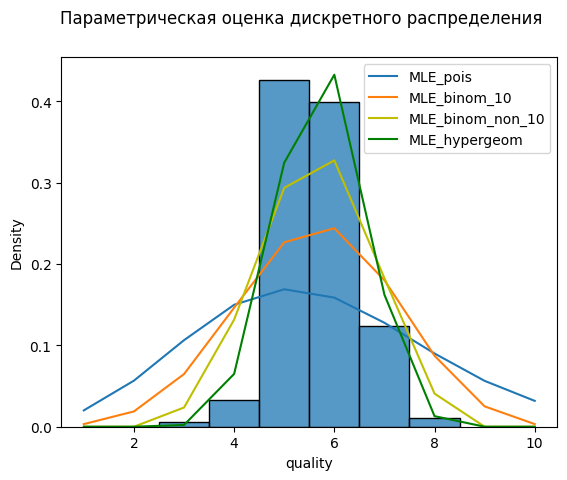

In [64]:
sns.histplot(data_select['quality'], stat='density', discrete=True)

x = np.arange(1, 11)
plt.plot(x, poisson.pmf(
    x, data_select['quality'].mean()), label='MLE_pois')

n = 10
p = data_select['quality'].mean()/n
plt.plot(x, binom.pmf(x, n, p), label='MLE_binom_10')

bounds = [(0, 15), (0, 15), (0, 15)]
res = fit(binom, data_select['quality'],  bounds, method='mle')

plt.plot(x, binom.pmf(
    x, *list(res.params)), c='y', label='MLE_binom_non_10')

bounds = [(0, 15), (0, 15), (0, 15), (0, 15)]
res = fit(hypergeom, data_select['quality'],  bounds, method='mle')

plt.plot(x, hypergeom.pmf(
    x, *list(res.params)), c='g', label='MLE_hypergeom')

plt.suptitle('Параметрическая оценка дискретного распределения')

plt.legend()
plt.show()

Если отойти от ограничения, что это 10 балльная шкала, то полученное распределение сильно лучше подходит для описания данных. Лучше всего подошло гипергеометрическое. Возникает проблема. Либо использовать распределение, которое основывается на точном знании, но которое хуже описывает имеющиеся данные. Либо использовать распределение, которое лучше подходит данным, но не совсем подходит по смыслу. Возможная проблема возникнет на этапе сэмплирования. Так как видно, что у нас просто не может возникнуть оценок меньше 3 и больше 8. Хотя шкала 10-ти балльная. Так как задача состоит в том, чтобы подобрать распределение, которое лучше всего подходит данным, мы выберем гипергеометрическое.

Теперь попробуем найти оценки параметров при помощи МНК. Сравним с уже полученными распределениями

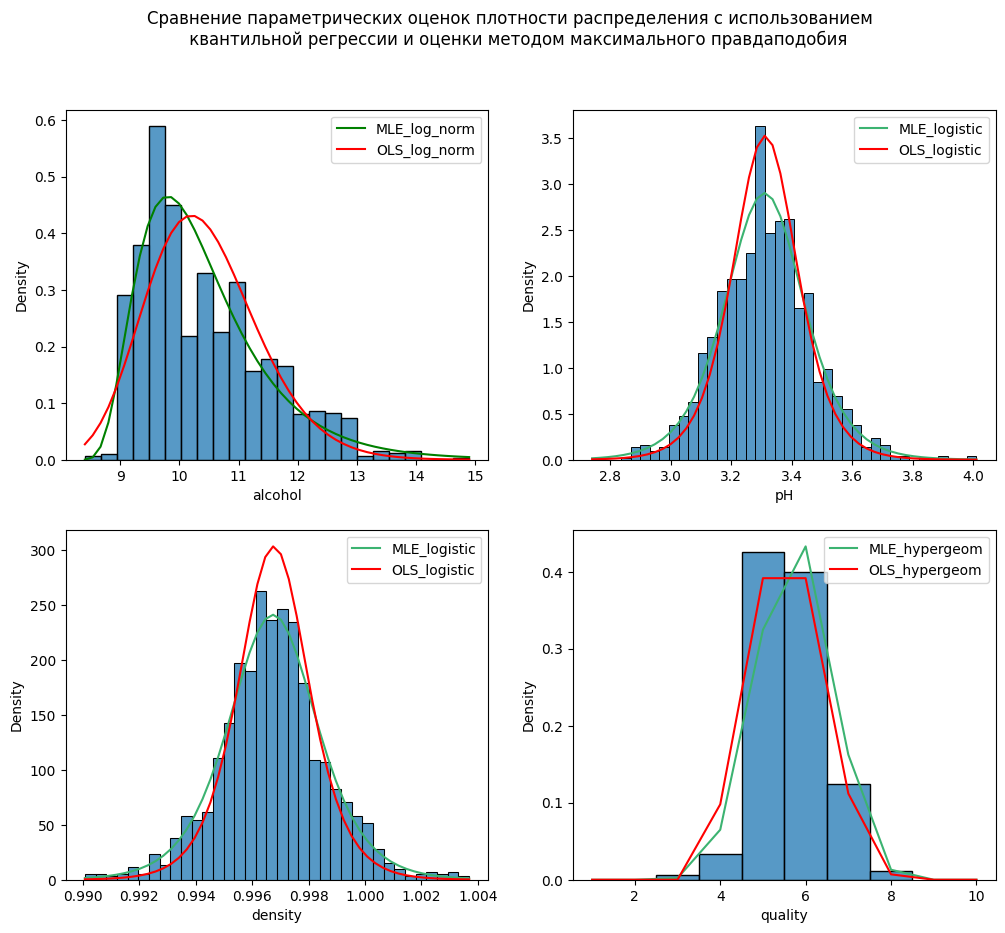

In [74]:
q = np.linspace(1e-5, 1-1e-5, 100)

# функции подсчета невязки


def ols_logistic(argum, data_quants):
    return np.sum((data_quants - logistic.ppf(q, argum[0], argum[1]))**2)


def ols_lognorm(argum, data_quants):
    return np.sum((data_quants - lognorm.ppf(q, argum[0], argum[1], argum[2]))**2)


def ols_hypergeom(argum, data_quants):
    return np.sum((data_quants - hypergeom.ppf(q, argum[0], argum[1], argum[2]))**2)


fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# alcohol


quantiles = np.quantile(data_select['alcohol'], q)
res = opt.minimize(ols_lognorm, [1, 1, 1],
                   args=(quantiles), method='Nelder-Mead')

x_ax = np.linspace(data_select['alcohol'].min(),
                   data_select['alcohol'].max())

lognorm_mle = lognorm.fit(data_select['alcohol'])
ax[0, 0].plot(x_ax, lognorm.pdf(x_ax, *lognorm_mle),
              c='g', label='MLE_log_norm')

sns.histplot(data_select['alcohol'], stat='density', ax=ax[0, 0])
ax[0, 0].plot(x_ax, lognorm.pdf(x_ax, *res['x']), c='r', label='OLS_log_norm')

ax[0, 0].legend()

# ph

quantiles = np.quantile(data_select['pH'], q)
res = opt.minimize(ols_logistic, [1, 1],
                   args=(quantiles), method='Nelder-Mead')

x_ax = np.linspace(data_select['pH'].min(),
                   data_select['pH'].max())

logistic_pH = logistic.fit(data_select['pH'])
ax[0, 1].plot(x_ax, logistic.pdf(x_ax,  *logistic_pH),
              c='mediumseagreen', label='MLE_logistic')

sns.histplot(data_select['pH'], stat='density', ax=ax[0, 1])
ax[0, 1].plot(x_ax, logistic.pdf(x_ax, *res['x']), c='r', label='OLS_logistic')

ax[0, 1].legend()

# density

quantiles = np.quantile(data_select['density'], q)
res = opt.minimize(ols_logistic, [1, 1],
                   args=(quantiles), method='Nelder-Mead')

x_ax = np.linspace(data_select['density'].min(),
                   data_select['density'].max())

logistic_density = logistic.fit(data_select['density'])
ax[1, 0].plot(x_ax, logistic.pdf(x_ax,  *logistic_density),
              c='mediumseagreen', label='MLE_logistic')

sns.histplot(data_select['density'], stat='density', ax=ax[1, 0])
ax[1, 0].plot(x_ax, logistic.pdf(x_ax, *res['x']), c='r', label='OLS_logistic')

ax[1, 0].legend()

# quality
# проблема в дискретной оптимизации
# Решим задачу перебором, так как вариантов не так много и это сильно проще
# Для более сложных задач, стоит пользоваться более эффективными алгоритмами
#

quantiles = np.quantile(data_select['quality'], q)

bounds = [(0, 15), (0, 15), (0, 15), (0, 15)]
hypergeom_MLE = fit(hypergeom, data_select['quality'],  bounds, method='mle')
hypergeom_MLE = list(hypergeom_MLE.params)

x = np.arange(1, 11)

ax[1, 1].plot(x, hypergeom.pmf(x, *hypergeom_MLE),
              c='mediumseagreen', label='MLE_hypergeom')


bounds = [15, 15, 15]

best_res = 100000000

opt_param = [0, 0, 0]

for arg_1 in range(bounds[0]):
    for arg_2 in range(bounds[1]):
        for arg_3 in range(bounds[2]):
            res_stage = ols_hypergeom([arg_1, arg_2, arg_3], quantiles)
            if res_stage < best_res:
                opt_param = [arg_1, arg_2, arg_3]
                best_res = res_stage


ax[1, 1].plot(x, hypergeom.pmf(x, *opt_param),
              c='r', label='OLS_hypergeom')

sns.histplot(data_select['quality'], stat='density',
             ax=ax[1, 1], discrete=True)


ax[1, 1].legend()

plt.suptitle('Сравнение параметрических оценок плотности распределения с использованием  \n квантильной регрессии и оценки методом максимального правдаподобия')

plt.show()

Чем больше квантилей мы берем, тем больше OLS оценка похожа на ММП. Особенно это хорощо видно для pH и density

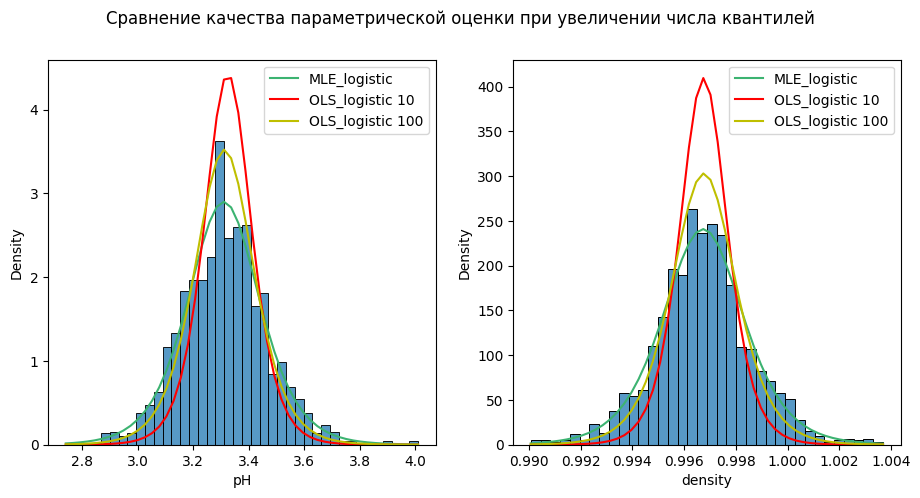

In [70]:


fig, ax = plt.subplots(1, 2, figsize=(11, 5))


# 100

q = np.linspace(1e-5, 1-1e-5, 10)


def ols_logistic(argum, data_quants):
    return np.sum((data_quants - logistic.ppf(q, argum[0], argum[1]))**2)


# ph

quantiles = np.quantile(data_select['pH'], q)
res = opt.minimize(ols_logistic, [1, 1],
                   args=(quantiles), method='Nelder-Mead')

x_ax = np.linspace(data_select['pH'].min(),
                   data_select['pH'].max())

loc, scale = logistic.fit(data_select['pH'])
ax[0].plot(x_ax, logistic.pdf(x_ax,  loc, scale),
           c='mediumseagreen', label='MLE_logistic')

sns.histplot(data_select['pH'], stat='density', ax=ax[0])
ax[0].plot(x_ax, logistic.pdf(x_ax, *res['x']),
           c='r', label='OLS_logistic 10')

q = np.linspace(1e-5, 1-1e-5, 100)


def ols_logistic(argum, data_quants):
    return np.sum((data_quants - logistic.ppf(q, argum[0], argum[1]))**2)


quantiles = np.quantile(data_select['pH'], q)
res = opt.minimize(ols_logistic, [1, 1],
                   args=(quantiles), method='Nelder-Mead')

ax[0].plot(x_ax, logistic.pdf(x_ax, *res['x']),
           c='y', label='OLS_logistic 100')


ax[0].legend()


# density

q = np.linspace(1e-5, 1-1e-5, 10)


def ols_logistic(argum, data_quants):
    return np.sum((data_quants - logistic.ppf(q, argum[0], argum[1]))**2)


quantiles = np.quantile(data_select['density'], q)
res = opt.minimize(ols_logistic, [1, 1],
                   args=(quantiles), method='Nelder-Mead')

x_ax = np.linspace(data_select['density'].min(),
                   data_select['density'].max())

loc, scale = logistic.fit(data_select['density'])
ax[1].plot(x_ax, logistic.pdf(x_ax,  loc, scale),
           c='mediumseagreen', label='MLE_logistic')

sns.histplot(data_select['density'], stat='density', ax=ax[1])
ax[1].plot(x_ax, logistic.pdf(x_ax, *res['x']), c='r', label='OLS_logistic 10')

q = np.linspace(1e-5, 1-1e-5, 100)


def ols_logistic(argum, data_quants):
    return np.sum((data_quants - logistic.ppf(q, argum[0], argum[1]))**2)


quantiles = np.quantile(data_select['density'], q)
res = opt.minimize(ols_logistic, [1, 1],
                   args=(quantiles), method='Nelder-Mead')

ax[1].plot(x_ax, logistic.pdf(x_ax, *res['x']),
           c='y', label='OLS_logistic 100')


ax[1].legend()

plt.suptitle(
    'Сравнение качества параметрической оценки при увеличении числа квантилей')

plt.show()

## Шаг 6

Проверьте оцененные параметры с помощью графика квантиль-квантиль (QQ).

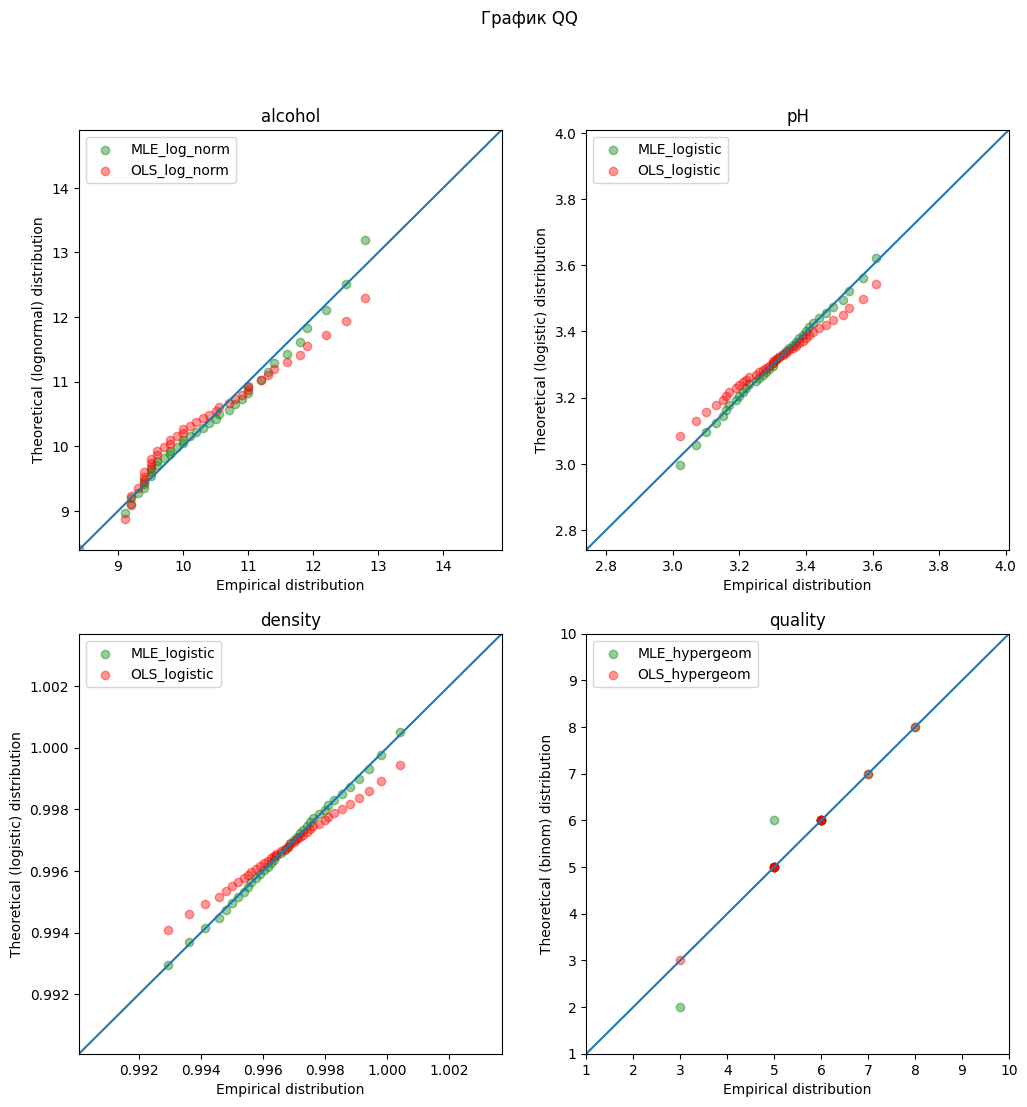

In [72]:
q = np.linspace(1e-5, 1-1e-5, 40)


def ols_logistic(argum, data_quants):
    return np.sum((data_quants - logistic.ppf(q, argum[0], argum[1]))**2)


def ols_lognorm(argum, data_quants):
    return np.sum((data_quants - lognorm.ppf(q, argum[0], argum[1], argum[2]))**2)


def ols_binom(argum, data_quants, n):
    return np.sum((data_quants - binom.ppf(q, n, argum[0]))**2)


fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# alcohol


quantiles = np.quantile(data_select['alcohol'], q)
res = opt.minimize(ols_lognorm, [1, 1, 1],
                   args=(quantiles), method='Nelder-Mead')

lognor = lognorm.fit(data_select['alcohol'])
ax[0, 0].scatter(quantiles, lognorm.ppf(q, a, loc, scale),
                 c='g', label='MLE_log_norm', alpha=0.4)

ax[0, 0].scatter(quantiles, lognorm.ppf(q, *res['x']),
                 c='r', label='OLS_log_norm', alpha=0.4)

ax[0, 0].plot([data_select['alcohol'].min(), data_select['alcohol'].max()],
              [data_select['alcohol'].min(), data_select['alcohol'].max()])

ax[0, 0].set_xlim([data_select['alcohol'].min(), data_select['alcohol'].max()])
ax[0, 0].set_ylim([data_select['alcohol'].min(), data_select['alcohol'].max()])

ax[0, 0].set_xlabel('Empirical distribution')
ax[0, 0].set_ylabel('Theoretical (lognormal) distribution')

ax[0, 0].set_title('alcohol')

ax[0, 0].legend()

# pH


quantiles = np.quantile(data_select['pH'], q)
res = opt.minimize(ols_logistic, [1, 1],
                   args=(quantiles), method='Nelder-Mead')

loc, scale = logistic.fit(data_select['pH'])
ax[0, 1].scatter(quantiles, logistic.ppf(q, loc, scale),
                 c='g', label='MLE_logistic', alpha=0.4)

ax[0, 1].scatter(quantiles, logistic.ppf(q, *res['x']),
                 c='r', label='OLS_logistic', alpha=0.4)

ax[0, 1].plot([data_select['pH'].min(), data_select['pH'].max()],
              [data_select['pH'].min(), data_select['pH'].max()])

ax[0, 1].set_xlim([data_select['pH'].min(), data_select['pH'].max()])
ax[0, 1].set_ylim([data_select['pH'].min(), data_select['pH'].max()])

ax[0, 1].set_xlabel('Empirical distribution')
ax[0, 1].set_ylabel('Theoretical (logistic) distribution')

ax[0, 1].set_title('pH')

ax[0, 1].legend()

# density


quantiles = np.quantile(data_select['density'], q)
res = opt.minimize(ols_logistic, [1, 1],
                   args=(quantiles), method='Nelder-Mead')

loc, scale = logistic.fit(data_select['density'])
ax[1, 0].scatter(quantiles, logistic.ppf(q, loc, scale),
                 c='g', label='MLE_logistic', alpha=0.4)

ax[1, 0].scatter(quantiles, logistic.ppf(q, *res['x']),
                 c='r', label='OLS_logistic', alpha=0.4)

ax[1, 0].plot([data_select['density'].min(), data_select['density'].max()],
              [data_select['density'].min(), data_select['density'].max()])

ax[1, 0].set_xlim([data_select['density'].min(), data_select['density'].max()])
ax[1, 0].set_ylim([data_select['density'].min(), data_select['density'].max()])

ax[1, 0].set_xlabel('Empirical distribution')
ax[1, 0].set_ylabel('Theoretical (logistic) distribution')

ax[1, 0].set_title('density')

ax[1, 0].legend()


# quality

q = np.linspace(0, 1, 11)

quantiles = np.quantile(data_select['quality'], q)

bounds = [(0, 15), (0, 15), (0, 15), (0, 15)]
res = fit(hypergeom, data_select['quality'],  bounds, method='mle')


x = np.arange(1, 11)


ax[1, 1].scatter(quantiles, hypergeom.ppf(q, *list(res.params)),
                 c='g', label='MLE_hypergeom', alpha=0.4)

ax[1, 1].scatter(quantiles, hypergeom.ppf(q, *opt_param),
                 c='r', label='OLS_hypergeom', alpha=0.4)

ax[1, 1].plot([1, 10],
              [1, 10])

ax[1, 1].set_xlim([1, 10])
ax[1, 1].set_ylim([1, 10])

ax[1, 1].set_xlabel('Empirical distribution')
ax[1, 1].set_ylabel('Theoretical (binom) distribution')

ax[1, 1].set_title('quality')


ax[1, 1].legend()

plt.suptitle('График QQ')

plt.show()

## Шаг 7

Оценить достоверность подогнанных распределений, используя не менее 2 статистических тестов.

Результаты тестов. В ячейке указан ответ на вопрос "Принимаем нулевую гипотезу?". Нулевая гипотеза: Два распределения идентичны. Указанные тесты подходят только для непрерывных распределений. Дискретное распределение quality будет рассмотренно отдельно


|         | Тест Колмогорова-Смирнова | Метод Монте-Карло | Тест Андерсона |
|---------|---------------------------|-------------------|----------------|
| alcohol | нет                       | нет               |Не подходит     |
| pH      | да                        | нет               |нет             |
| density | да                        | да                |да              |

Для проверки дискретного распределения использовались два теста ($\chi^2$ и power power_divergence). В тесте power_divergence можно использовать различные статистики в том числе Пирсона. Тогда тест эквивалентен $\chi^2$. Нулевая гипотеза для обоих тестов "категориальная переменная имеет заданную частотность" (null hypothesis that the categorical data has the given frequencies). $\chi^2$ показал, что нам стоит отклонить нулевую гипотезу. power_divergence со статистикой (Modified log-likelihood ratio) наоборот не отвергает нулевую гипотезу.

Тест Колмогорова-Смирнова

In [78]:
# alcohol
# p-value < 5%
# Не принимаем нулевую гипотезу => эмперическое распределения не является логнормальным
ks = kstest(data_select['alcohol'], 'lognorm', lognorm_mle, N=100)
print(ks)

KstestResult(statistic=0.08548764825189814, pvalue=1.291248266015785e-10, statistic_location=9.5, statistic_sign=1)


In [15]:
# pH
# p-value > 5%
# Не отвергаем нулевую гипотезу => эмперическое распределения является логистическим
ks = kstest(data_select['pH'], 'logistic', logistic_pH, N=100)
print(ks)

KstestResult(statistic=0.028151376249648974, pvalue=0.15557894037378173, statistic_location=3.22, statistic_sign=1)


In [16]:
# density
# p-value > 5%
# Не отвергаем нулевую гипотезу => эмперическое распределения является логистическим
ks = kstest(data_select['density'], 'logistic', logistic_density, N=100)
print(ks)

KstestResult(statistic=0.021759984907581242, pvalue=0.42922432696105184, statistic_location=0.9976, statistic_sign=1)


Обобщенная процедур проверки принадлежности распределению по методу Монте-Карло (generalized Monte Carlo goodness-of-fit procedure)

In [17]:
# alcohol
# p-value < 5%
# Не принимаем нулевую гипотезу => эмперическое распределения не является логнормальным
test_res = goodness_of_fit(lognorm, data_select['alcohol'])
print(test_res)

GoodnessOfFitResult(fit_result=  params: FitParams(s=0.45966602469809614, loc=8.121607798120905, scale=2.073526797137148)
 success: True
 message: 'The fit was performed successfully.', statistic=10.927241176845428, pvalue=0.0001, null_distribution=array([0.69525981, 0.19581091, 0.35518727, ..., 0.55857392, 0.19491728,
       0.36414745]))


In [18]:
# pH
# p-value < 5%
# Отвергаем нулевую гипотезу => эмперическое распределения не является логистическим
test_res = goodness_of_fit(logistic, data_select['pH'])
print(test_res)

GoodnessOfFitResult(fit_result=  params: FitParams(loc=3.3095177374890055, scale=0.08618406085263104)
 success: True
 message: 'The fit was performed successfully.', statistic=0.9002969838065837, pvalue=0.0117, null_distribution=array([0.64925119, 0.42728668, 1.21730852, ..., 0.24968318, 0.50661504,
       0.25041856]))


In [19]:
# density
# p-value > 5%
# Не отвергаем нулевую гипотезу => эмперическое распределения является логистическим
test_res = goodness_of_fit(logistic, data_select['density'])
print(test_res)

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.9967333996520806, scale=0.0010376774766219677)
 success: True
 message: 'The fit was performed successfully.', statistic=0.5366215692961305, pvalue=0.1188, null_distribution=array([0.21015539, 0.15680114, 0.23937304, ..., 0.22968334, 0.18382977,
       0.48856545]))


Тест Андерсона

In [239]:
# pH
# На уровне значимости 5% статистика превышает критическое значение
# Отвергаем нулевую гипотезу => эмперическое распределения не является логистическим
anderson(data_select['pH'], 'logistic')

AndersonResult(statistic=0.9002970545559492, critical_values=array([0.426, 0.563, 0.66 , 0.769, 0.906, 1.01 ]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5]), fit_result=  params: FitParams(loc=3.3095177415442754, scale=0.08618406010195252)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [240]:
# density
# На уровне значимости 5% статистика не превышает критическое значение
# Не отвергаем нулевую гипотезу => эмперическое распределения является логистическим
anderson(data_select['density'], 'logistic')

AndersonResult(statistic=0.5366361732330915, critical_values=array([0.426, 0.563, 0.66 , 0.769, 0.906, 1.01 ]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5]), fit_result=  params: FitParams(loc=0.9967333813042687, scale=0.0010376822382037938)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Проверки для quality

In [75]:
# null hypothesis that the categorical data has the given frequencies (из документации)
# p-value < 5%
# Отвергаем нулевую гипотезу
obs_freq = (data_select['quality'].value_counts(
).sort_index() / data_select['quality'].shape[0]).to_list()
x = data_select['quality'].value_counts().sort_index().index.to_list()
exp_freq = hypergeom.pmf(x, *opt_param)
chi = chisquare(obs_freq, exp_freq)
print(chi)

Power_divergenceResult(statistic=inf, pvalue=0.0)


In [76]:
# null hypothesis that the categorical data has the given frequencies (из документации)
# p-value > 5%
# Принимаем нулевую гипотезу
pow_div = power_divergence(obs_freq, exp_freq, lambda_='mod-log-likelihood')
print(pow_div)

Power_divergenceResult(statistic=0.1012193228807955, pvalue=0.9998327627485094)


## Шаг 8

Используя одномерные параметрические распределения, которые были подобраны, выполните семплирование СВ. Используйте для этого не менее 2 различных методов семплирования.

Метод обратного преобразования

Будем использовать квантильные функции. Если для логистического распределения получить квантильную функцию не вызывает никаких проблем, то для логнормального и гипергеометрического все не так просто. Однако эти функции реализованы в scipy и будем надеяться, что все работает правильно.

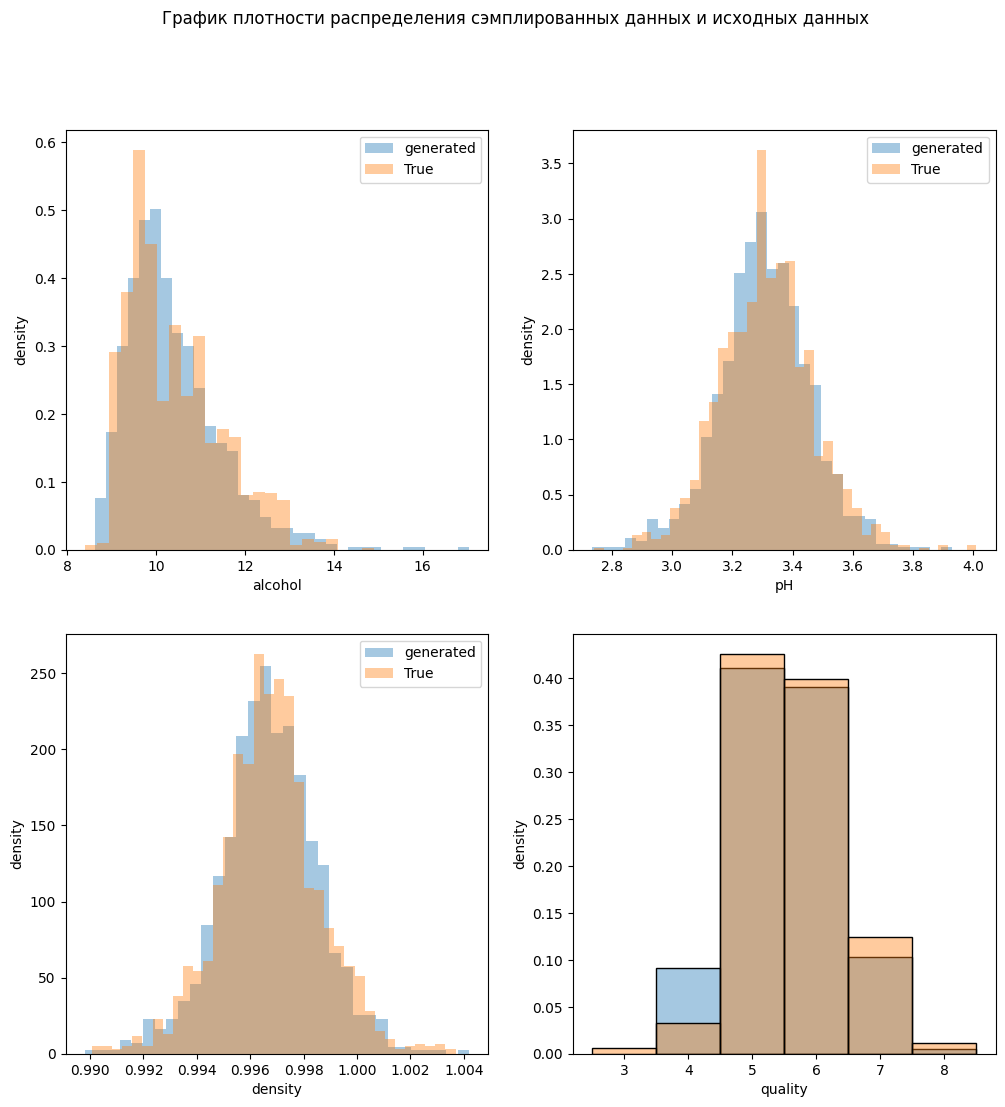

In [262]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# alcohol

quants = np.random.uniform(0, 1, 1000)

x_vals = lognorm.ppf(quants, *lognorm_mle)

ax[0, 0].hist(x_vals, label='generated', density=True, alpha=0.4, bins='auto')
ax[0, 0].hist(data_select['alcohol'], label='True',
              density=True, alpha=0.4, bins='auto')
ax[0, 0].legend()
ax[0, 0].set_xlabel('alcohol')
ax[0, 0].set_ylabel('density')

# pH

x_vals = logistic.ppf(quants, *logistic_pH)

ax[0, 1].hist(x_vals, label='generated', density=True, alpha=0.4, bins='auto')
ax[0, 1].hist(data_select['pH'], label='True',
              density=True, alpha=0.4, bins='auto')
ax[0, 1].legend()
ax[0, 1].set_xlabel('pH')
ax[0, 1].set_ylabel('density')

# density

x_vals = logistic.ppf(quants, *logistic_density)

ax[1, 0].hist(x_vals, label='generated', density=True, alpha=0.4, bins='auto')
ax[1, 0].hist(data_select['density'], label='True',
              density=True, alpha=0.4, bins='auto')
ax[1, 0].legend()
ax[1, 0].set_xlabel('density')
ax[1, 0].set_ylabel('density')

# quality

x_vals = hypergeom.ppf(quants, *opt_param)

sns.histplot(x_vals, stat='density', alpha=0.4,
             discrete=True, ax=ax[1, 1])
sns.histplot(data_select['quality'], stat='density',
             alpha=0.4, discrete=True, ax=ax[1, 1])

ax[1, 1].set_xlabel('quality')
ax[1, 1].set_ylabel('density')

plt.suptitle(
    'График плотности распределения сэмплированных данных и исходных данных')

plt.show()

Выборка с отклонением. Сначала надо подобрать нормирующую константу для каждого распределения. Помним про ограничение на неотрицательность!

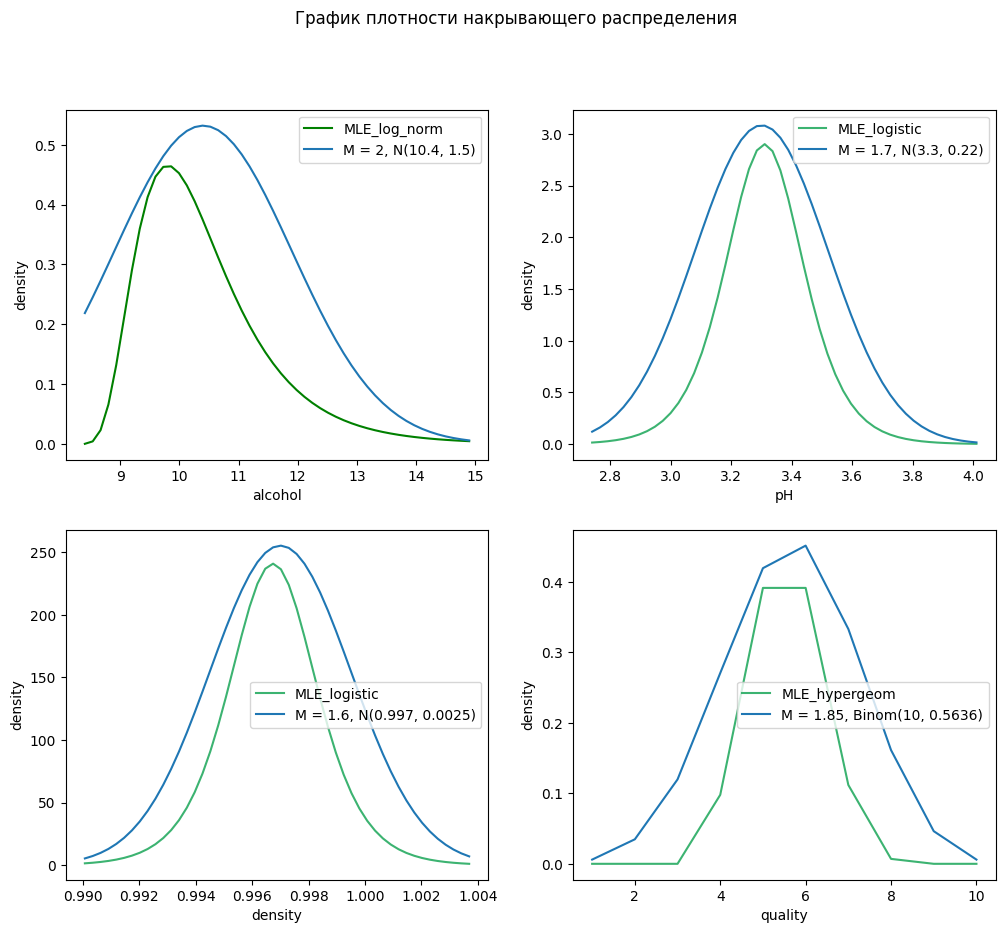

In [261]:
q = np.linspace(1e-5, 1-1e-5, 100)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# alcohol


x_ax = np.linspace(data_select['alcohol'].min(),
                   data_select['alcohol'].max())

ax[0, 0].plot(x_ax, lognorm.pdf(x_ax, *lognorm_mle),
              c='g', label='MLE_log_norm')


M_alc = 2

norm_params_alc = [round(data_select['alcohol'].mean(), 1), 1.5]

ax[0, 0].plot(x_ax, M_alc * norm.pdf(x_ax, *norm_params_alc),
              label=f'M = {M_alc}, N({norm_params_alc[0]}, {norm_params_alc[1]})')

ax[0, 0].legend()

ax[0, 0].set_xlabel('alcohol')
ax[0, 0].set_ylabel('density')


# ph

x_ax = np.linspace(data_select['pH'].min(),
                   data_select['pH'].max())


ax[0, 1].plot(x_ax, logistic.pdf(x_ax,  *logistic_pH),
              c='mediumseagreen', label='MLE_logistic')

M_ph = 1.7

norm_params_ph = [round(data_select['pH'].mean(), 1), 0.22]

ax[0, 1].plot(x_ax, M_ph * norm.pdf(x_ax, *norm_params_ph),
              label=f'M = {M_ph}, N({norm_params_ph[0]}, {norm_params_ph[1]})')

ax[0, 1].legend()

ax[0, 1].set_xlabel('pH')
ax[0, 1].set_ylabel('density')


# density

x_ax = np.linspace(data_select['density'].min(),
                   data_select['density'].max())


ax[1, 0].plot(x_ax, logistic.pdf(x_ax,  *logistic_density),
              c='mediumseagreen', label='MLE_logistic')

M_dens = 1.6

norm_param_dens = [round(data_select['density'].mean(), 3), 0.0025]

ax[1, 0].plot(x_ax, M_dens * norm.pdf(x_ax, *norm_param_dens),
              label=f'M = {M_dens}, N({norm_param_dens[0]}, {norm_param_dens[1]})')


ax[1, 0].legend()

ax[1, 0].set_xlabel('density')
ax[1, 0].set_ylabel('density')


# quality

x = np.arange(1, 11)

ax[1, 1].plot(x, hypergeom.pmf(x, *opt_param),
              c='mediumseagreen', label='MLE_hypergeom')


M_qua = 1.85

binom_params_qua = [10, round(data_select['quality'].mean()/10, 4)]


ax[1, 1].plot(x, M_qua * binom.pmf(x, *binom_params_qua),
              label=f'M = {M_qua}, Binom({binom_params_qua[0]}, {binom_params_qua[1]})')


ax[1, 1].legend()

ax[1, 1].set_xlabel('quality')
ax[1, 1].set_ylabel('density')

plt.suptitle('График плотности накрывающего распределения')

plt.show()

In [246]:
# Функции сэмплирования данных
# Для непрерывной случайной величены
# Позаимствована из кода для МК4

def sample_distrib(target_func, target_func_params, M, norm_args):
    ''' 
    Функция сэмплирования данных для непрерывной случайной величены методом выборки с отклонением при помощи нормального распредления

    Args:

        target_func - распределение, для которого надо сэмплировать данные

        target_func_params - параметры сэмплируемого распределения

        M - нормирующая константа

        norm_args - параметры нормального распределения

    Returns:

        сэмплированные данные
    '''
    samples = []
    N = 100000
    for _ in range(N):
        # get a candidate from normal distribution
        candidate = np.random.normal(*norm_args)

        # calculate probabailty of accepting this sample
        prob_accept = target_func.pdf(
            candidate, *target_func_params) / (M * norm.pdf(candidate, *norm_args))

        # accept sample with this probability
        if np.random.random() < prob_accept:
            samples.append(candidate)
    return samples

# Для дискретной


def sample_distrib_descr(target_func, target_func_params, M, binom_args):
    ''' 
    Функция сэмплирования данных для дискретной случайной величены методом выборки с отклонением при помощи биномиального распредления

    Args:

        target_func - распределение, для которого надо сэмплировать данные

        target_func_params - параметры сэмплируемого распределения

        M - нормирующая константа

        binom_args - параметры биномиального распределения

    Returns:

        сэмплированные данные
    '''

    samples = []
    N = 1000
    for _ in range(N):
        # get a candidate from binomial distribution
        candidate = np.random.binomial(*binom_args)

        # calculate probabailty of accepting this sample
        prob_accept = target_func.pmf(
            candidate, *target_func_params) / (M * binom.pmf(candidate, *binom_args))

        # accept sample with this probability
        if np.random.random() < prob_accept:
            samples.append(candidate)
    return samples

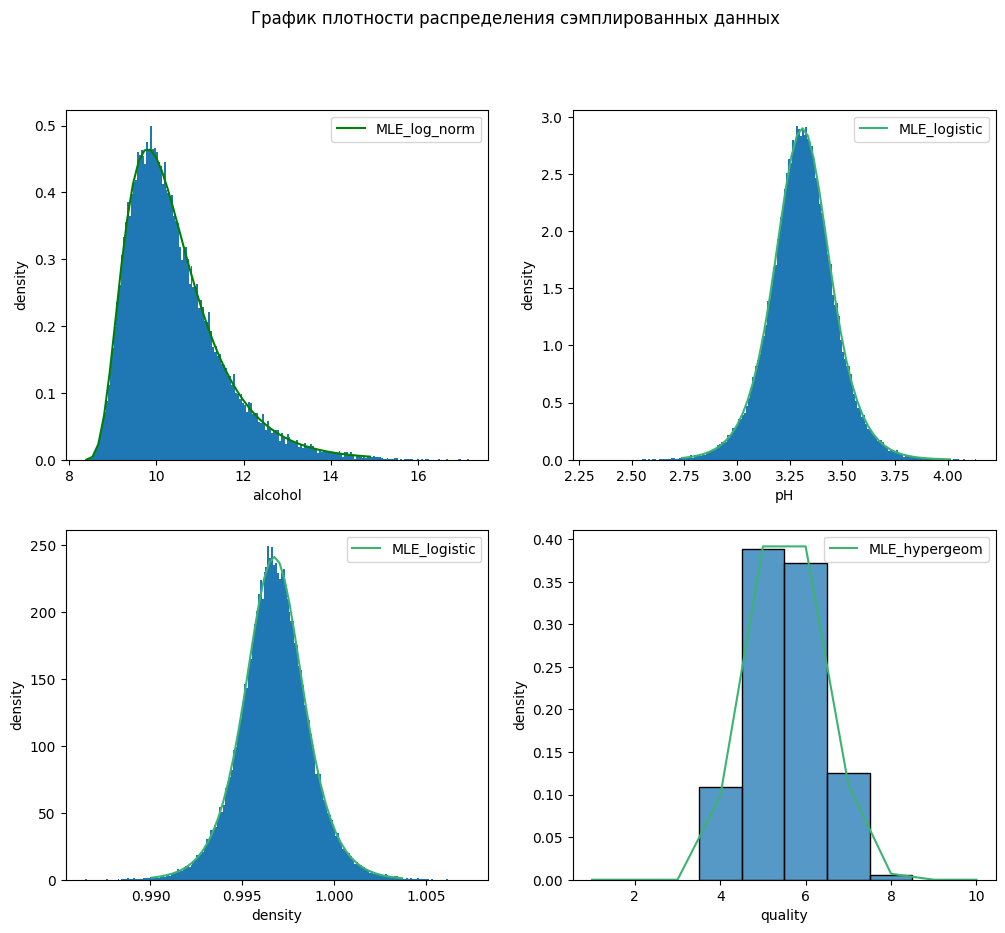

In [260]:
q = np.linspace(1e-5, 1-1e-5, 100)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# alcohol


x_ax = np.linspace(data_select['alcohol'].min(),
                   data_select['alcohol'].max())

ax[0, 0].plot(x_ax, lognorm.pdf(x_ax, *lognorm_mle),
              c='g', label='MLE_log_norm')

sampled = sample_distrib(lognorm, lognorm_mle, M_alc, norm_params_alc)

ax[0, 0].hist(sampled, bins=200, density=True)

ax[0, 0].legend()

ax[0, 0].set_xlabel('alcohol')
ax[0, 0].set_ylabel('density')


# ph

x_ax = np.linspace(data_select['pH'].min(),
                   data_select['pH'].max())


ax[0, 1].plot(x_ax, logistic.pdf(x_ax,  *logistic_pH),
              c='mediumseagreen', label='MLE_logistic')

sampled = sample_distrib(logistic, logistic_pH, M_ph, norm_params_ph)

ax[0, 1].hist(sampled, bins=200, density=True)

ax[0, 1].legend()

ax[0, 1].set_xlabel('pH')
ax[0, 1].set_ylabel('density')


# density

x_ax = np.linspace(data_select['density'].min(),
                   data_select['density'].max())


ax[1, 0].plot(x_ax, logistic.pdf(x_ax,  *logistic_density),
              c='mediumseagreen', label='MLE_logistic')

sampled = sample_distrib(logistic, logistic_density, M_dens, norm_param_dens)

ax[1, 0].hist(sampled, bins=200, density=True)


ax[1, 0].legend()

ax[1, 0].set_xlabel('density')
ax[1, 0].set_ylabel('density')


# quality

x = np.arange(1, 11)

ax[1, 1].plot(x, hypergeom.pmf(x, *opt_param),
              c='mediumseagreen', label='MLE_hypergeom')


x_ax = np.linspace(0, 10)

sampled = sample_distrib_descr(
    hypergeom, opt_param, M_qua, binom_params_qua)

sns.histplot(sampled, stat='density', ax=ax[1, 1], discrete=True)


ax[1, 1].legend()

ax[1, 1].set_xlabel('quality')
ax[1, 1].set_ylabel('density')

plt.suptitle('График плотности распределения сэмплированных данных')


plt.show()